# Coffee in Manhattan

In a fix, which coffee chain is easier to find, Starbucks, or Dunkin? To answer that question, we will look at a list of all Dunkin' and Starbucks storefronts in Manhattan, and see the distance between each store and their nearest competitor.

In [103]:
import geopy.distance
import pandas as pd
import psycopg2

import sys
sys.path.append("../")
import private

def get_dataframe_from_db(query):

    with psycopg2.connect(private.AWS_CONNECTION_STRING) as conn:

        df = pd.read_sql(
            sql = query,
            con = conn
        )

    return df

def get_distance_between_stores(row):
    location_1 = (row['latitude_starbucks'], row['longitude_starbucks'])
    location_2 = (row['latitude_dunkin'], row['longitude_dunkin'])
    distance_between_stores = geopy.distance.distance(location_1, location_2).meters
    
    return round(distance_between_stores)

QUERY = '''
with base_data as (

    select
        vicinity as address,
        result_name,
        max(location_latitude) as latitude,
        max(location_longitude) as longitude
    from locations_data.manhattan_coffee
    group by 1,2
    )

select
    t.address as address_starbucks,
    t.latitude as latitude_starbucks,
    t.longitude as longitude_starbucks,
    t2.address as address_dunkin,
    t2.latitude as latitude_dunkin,
    t2.longitude as longitude_dunkin
from base_data as t
cross join base_data as t2
where t.result_name = 'Starbucks'
    and t2.result_name ~ 'Dunk'
    and t.address ~ 'New York'
    and t2.address ~ 'New York';
'''

df = get_dataframe_from_db(QUERY)
df['distance_between_stores'] = df.apply(get_distance_between_stores, axis = 1)

df.sort_values(by = ['distance_between_stores']).head()

,address_starbucks,latitude_starbucks,longitude_starbucks,address_dunkin,latitude_dunkin,longitude_dunkin,distance_between_stores
9903,"229 7th Ave, New York",40.744294,-73.995276,"225 7th Ave, New York",40.744251,-73.995319,6.0
8370,"875 3rd Ave, New York",40.757430,-73.969128,"875 3rd Ave, New York",40.757194,-73.969186,27.0
17191,"120 Church St, New York",40.713782,-74.009077,"130 Church St, New York",40.714031,-74.008954,30.0
21402,"130 Fulton St, New York",40.710194,-74.007894,"122 Fulton St, New York",40.709975,-74.007615,34.0
20514,"360 Lexington Ave, New York",40.750319,-73.977050,"370 Lexington Ave, New York",40.750670,-73.976876,42.0


In [104]:
df['rank_starbucks'] = df.groupby('address_starbucks')['distance_between_stores'].rank(ascending=True)
df['rank_dunkin'] = df.groupby('address_dunkin')['distance_between_stores'].rank(ascending=True)

df_starbucks = df[df['rank_starbucks'] == 1]
df_dunkin = df[df['rank_dunkin'] == 1]

# What is the Competition Function?

What percent of each coffee chain have a competitor within N meters?

In [110]:
def share_of_stores_without_comp(df, distance):
    df['threshold_distance'] = ['yes' if x < distance else 'no' for x in df['distance_between_stores']]

    number_of_stores = df\
        .groupby('threshold_distance')['distance_between_stores']\
        .agg('count')['yes']
    
    total_stores = float(df.shape[0])
    
    return 1 - number_of_stores/total_stores

In [113]:
empty_list = []
for i in range(10, 250, 10):
    thing = {
        'distance': i,
        'starbucks': share_of_stores_without_comp(df_starbucks, i),
        'dunkin': share_of_stores_without_comp(df_dunkin, i)
    }
    empty_list.append(thing)
    
df_final = pd.DataFrame(empty_list)

/Users/b/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


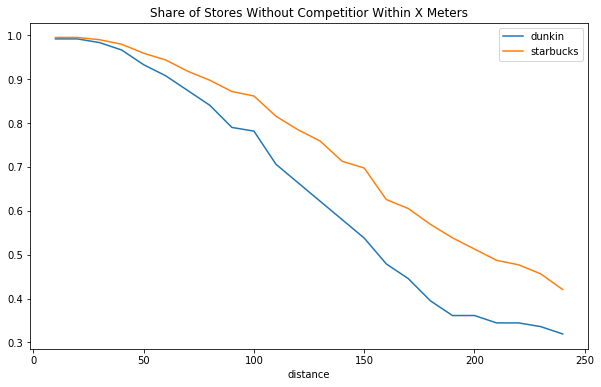

In [114]:
df_final\
    .set_index('distance')\
    .plot(
        title = "Share of Stores Without Competitior Within X Meters", 
        figsize = (10,6))


## Notes

Follow Up Questions:
1. What % of stores have an immediate competitor? Less than 100 meters?
2. What are the counts and store share per zipcode?